# Generate tiled AOIs covering Local Government Areas (LGAs)

In [1]:
# Necessary imports
import os
import itertools
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from ml4floods.data import utils
from ml4floods.data.copernicusEMS.activations import generate_polygon
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings('ignore', 'Geometry is in a ', UserWarning)

In [2]:
# Access parameters for the ML4CC bucket
key_json = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/ml4cc-general-access_request_pays.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_json

## Load the NRRA-supplied local government area (LGA) polygons

In [4]:
# Read in the LGA shapefile and get a tuple of bounds (used for tiling later)
input_shapefile = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/AOIs/2022-07-20/Declarations_19722_Merge.shp"
lgas = gpd.read_file(input_shapefile).to_crs("EPSG:4326")
bounds_lgas = np.min(lgas.bounds.minx), np.min(lgas.bounds.miny), np.max(lgas.bounds.maxx), np.max(lgas.bounds.maxy)
print(f"[minX, minY, maxX, maxY] = {bounds_lgas}")
lgas.head()

[minX, minY, maxX, maxY] = (147.0996031608572, -35.64460560526442, 153.02036763086153, -30.40230546812279)


,LGA_CODE21,LGA_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,Area_Ha,Shape_Le_1,Shape_Area,OBJECTID__,Shape__,LGA_CODE_1,LGA_NAME_1,No__Disast,Shape_Le_2,Shape_Ar_1,geometry
0,15850,Narromine,1,New South Wales,Aus,Australia,5261.5165,http://linked.data.gov.au/dataset/asgsed3/LGA2...,0.000000,0.000000,0.000000,0.000000,0.0,Polygon,15850.0,Narromine,7.0,4.154637,0.503372,"POLYGON ((147.62222 -32.27942, 147.62209 -32.2..."
1,16100,Oberon,1,New South Wales,Aus,Australia,3625.0470,http://linked.data.gov.au/dataset/asgsed3/LGA2...,0.000000,0.000000,0.000000,0.000000,0.0,Polygon,16100.0,Oberon,9.0,4.840998,0.353274,"POLYGON ((149.61555 -33.70254, 149.61556 -33.7..."
2,17100,Strathfield,1,New South Wales,Aus,Australia,14.0008,http://linked.data.gov.au/dataset/asgsed3/LGA2...,0.000000,0.000000,0.000000,0.000000,0.0,Polygon,0.0,Strathfield,0.0,0.207187,0.001364,"POLYGON ((151.06433 -33.87054, 151.06332 -33.8..."
3,10500,Bayside (NSW),1,New South Wales,AUS,Australia,50.6204,http://linked.data.gov.au/dataset/asgsed3/LGA2...,0.576415,5062.303066,0.576415,0.004937,1.0,Polygon,10500.0,Bayside (NSW),3.0,0.576415,0.004937,"POLYGON ((151.14805 -33.92725, 151.14858 -33.9..."
4,10750,Blacktown,1,New South Wales,AUS,Australia,238.8471,http://linked.data.gov.au/dataset/asgsed3/LGA2...,0.741291,23884.819558,0.741291,0.023239,2.0,Polygon,10750.0,Blacktown,4.0,0.741291,0.023239,"POLYGON ((150.87089 -33.82385, 150.87078 -33.8..."


<AxesSubplot:>

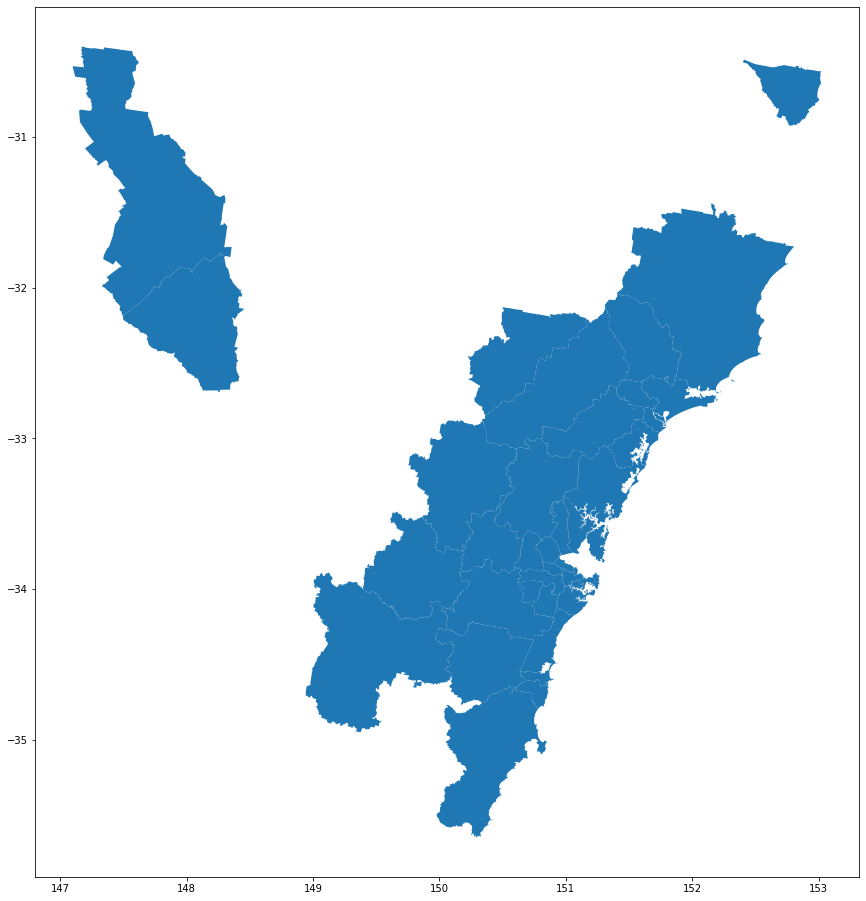

In [5]:
# Plot the LGAs
lgas.plot(figsize=(16, 16))

## Access and parse existing polygons on the bucket

In [6]:
# Access the Google bucket using fsutil
fs = utils.get_filesystem("gs://ml4cc_data_lake")
path_pols_existing = "gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR586/*/flood_meta/2022-*"

# Read existing polygons from pickles on bucket. Stored in pickels named:
# 0_DEV/1_Staging/operational/<EMS_CODE>/AOI*/flood_meta/2022-??-??.pickle
pols_existing = []
for meta_file in tqdm(fs.glob(path_pols_existing)):
    meta_file = f"gs://{meta_file}"
    meta = utils.read_pickle_from_gcp(meta_file)
    pols_existing.append({"geometry":meta["area_of_interest_polygon"], 
                          "ems_code":meta["ems_code"], 
                          "aoi_code":meta["aoi_code"], 
                          "date":meta["satellite date"]})
pols_existing = gpd.GeoDataFrame(pols_existing, crs="EPSG:4326")
pols_existing.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 481/481 [04:45<00:00,  1.69it/s]


,geometry,ems_code,aoi_code,date
0,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2...",EMSR586,AOI01,2022-06-27
1,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2...",EMSR586,AOI01,2022-07-05
2,"POLYGON ((147.09960 -31.04462, 147.30960 -31.0...",EMSR586,AOI02,2022-06-27
3,"POLYGON ((147.09960 -31.04462, 147.30960 -31.0...",EMSR586,AOI02,2022-07-05
4,"POLYGON ((147.49960 -32.44461, 147.70960 -32.4...",EMSR586,AOI0289,2022-06-27


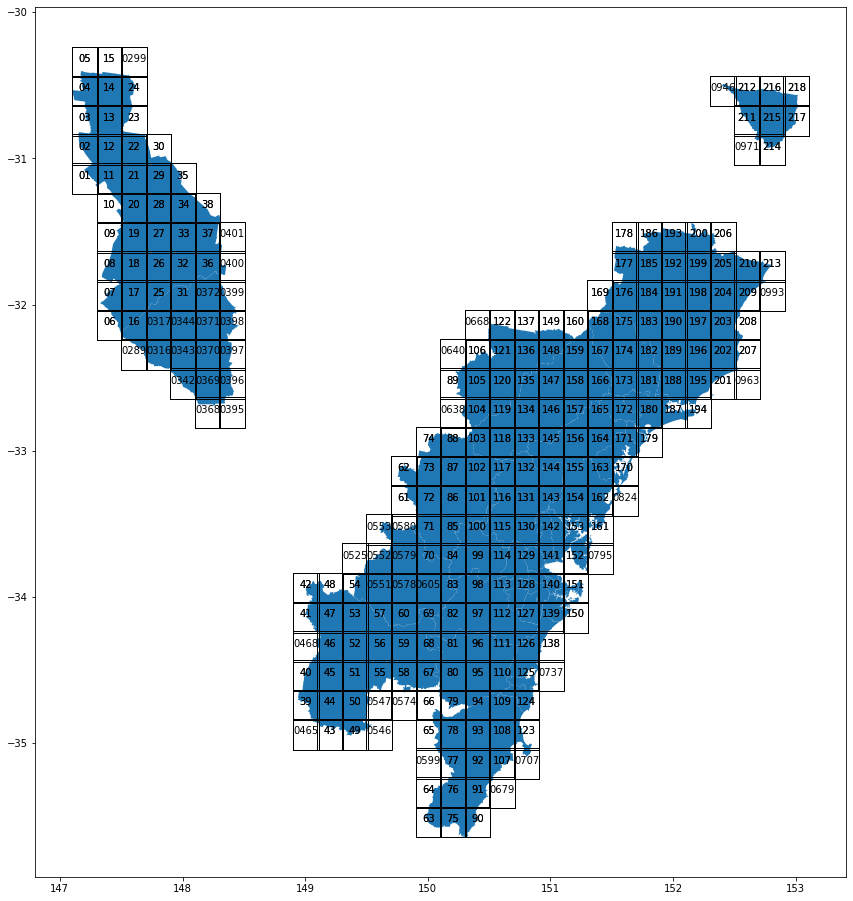

In [7]:
# Plot the existing polygons
ax = lgas.plot(figsize=(16, 16))
pols_existing.plot(ax=ax, facecolor="none")
for cent_x, cent_y, aoi_lab in zip(pols_existing.geometry.centroid.x, 
                                   pols_existing.geometry.centroid.y, 
                                   pols_existing.aoi_code):
    ax.annotate(aoi_lab[3:], (cent_x, cent_y), horizontalalignment='center')

In [9]:
# Save the existing polygons locally
out_file = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/AOIs_existing/2022-07-21_aois.geojson"
pols_existing[["geometry","aoi_code"]].to_file(out_file,driver="GeoJSON")

## Generate new polygon tiles to fill gaps

In [8]:
verbose = False

# Set the tiling step and square tile size
step = 0.20, 0.20
size = 0.21

# Determine the maximum existing AOI code
idx_offset = max([int(x[3:]) for x in pols_existing.aoi_code.values])

# Iterate in X and Y from min_x and min_y to generate tiles
# bounds_lgas = [min_x, min_y, max_x, max_y]
pols_new = []
for idx, (x_left,y_bottom) in enumerate(itertools.product(np.arange(bounds_lgas[0], bounds_lgas[2], step[0]),
                                                          np.arange(bounds_lgas[1],bounds_lgas[3], step[1]))):
    
    aoi_num = idx + idx_offset + 1
    # Generate tile 
    bounds_iter = (x_left, y_bottom, x_left + size, y_bottom + size)
    pol = Polygon(generate_polygon(bounds_iter))
    
    # Calculate the intersection of the tile with the LGAs
    lgas_overlap_polygons = lgas.intersection(pol)
    lgas_overlap_polygons = lgas_overlap_polygons[~lgas_overlap_polygons.is_empty].copy()
    
    # Skip tile if it does not overlap any LGA
    if lgas_overlap_polygons.shape[0] == 0:
        continue
        
    # Skip tile if the LGA occupies < 0.2 of tile area
    min_frac_area = 0.01
    area_overlap_lga = lgas_overlap_polygons.area.sum() / pol.area
    if area_overlap_lga <= min_frac_area:
        if verbose:
            print(f"Skipping Tile {aoi_num} because of low filling fraction.")
        continue
    
    # Calculate the intersection of the tile with the existing polygons
    aoi_overlap_polygons = pols_existing.intersection(pol)
    aoi_overlap_polygons = aoi_overlap_polygons[~aoi_overlap_polygons.is_empty].copy()
    
    # Skip tile if it significantly overlaps any existing polygon
    max_frac_overlap = 0.3
    area_overlap = aoi_overlap_polygons.area.sum() / pol.area
    if area_overlap >= max_frac_overlap:
        if verbose:
            print(f"Skipping Tile {aoi_num} because of high overlap with existing tile.")
        continue
    if verbose:
        print(f"appending name AOI {aoi_num:04d}")
    pols_new.append({"geometry": pol, "name":f"AOI{aoi_num:04d}"})
    
pols_new = gpd.GeoDataFrame(pols_new, crs="EPSG:4326")
print(f"Added {pols_new.shape[0]} tiles.")
pols_new.head()

Added 45 tiles.


,geometry,name
0,"POLYGON ((147.49960 -32.44461, 147.70960 -32.4...",AOI0289
1,"POLYGON ((147.49960 -30.44461, 147.70960 -30.4...",AOI0299
2,"POLYGON ((147.69960 -32.44461, 147.90960 -32.4...",AOI0316
3,"POLYGON ((147.69960 -32.24461, 147.90960 -32.2...",AOI0317
4,"POLYGON ((147.89960 -32.64461, 148.10960 -32.6...",AOI0342


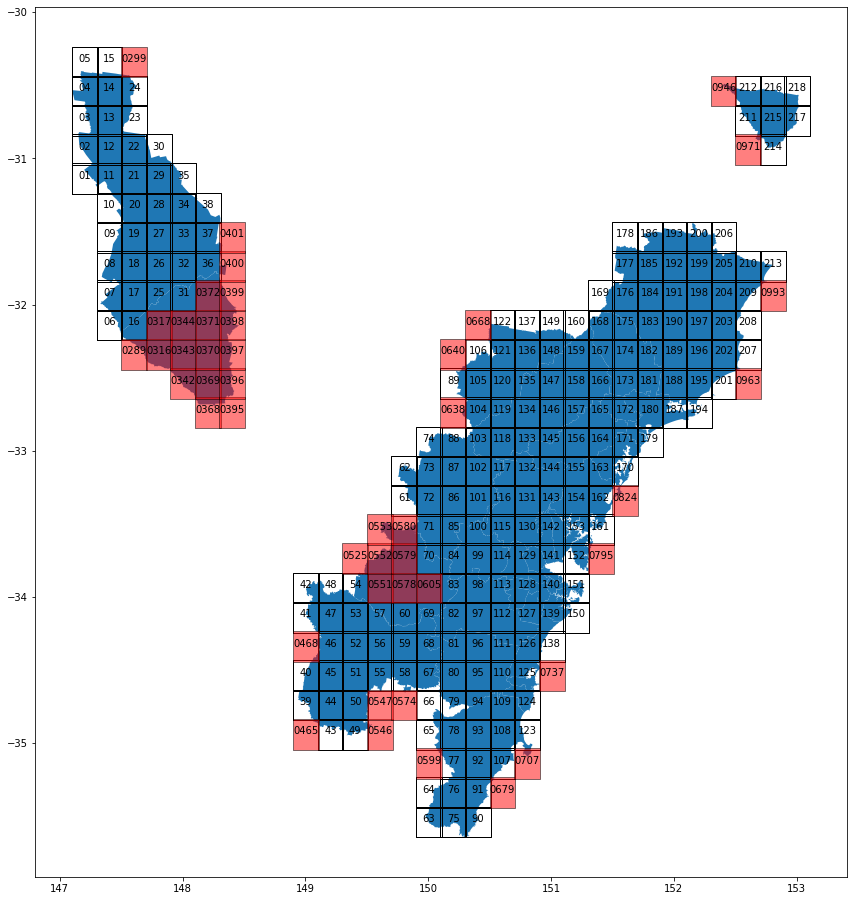

In [9]:
# Plot the old tiles and new (red)
ax = lgas.plot(figsize=(16, 16))
pols_existing.plot(ax=ax, facecolor="none")
pols_new.plot(ax=ax, edgecolor='black', facecolor='red', alpha=0.5)
for cent_x, cent_y, aoi_lab in zip(pols_existing.geometry.centroid.x,
                                   pols_existing.geometry.centroid.y,
                                   pols_existing.aoi_code):
    ax.annotate(aoi_lab[3:], (cent_x, cent_y), horizontalalignment='center')

for cent_x, cent_y, aoi_lab in zip(pols_new.geometry.centroid.x,
                                   pols_new.geometry.centroid.y,
                                   pols_new.name):
    ax.annotate(aoi_lab[3:], (cent_x, cent_y), horizontalalignment='center')

In [10]:
# Save new polygons locally
out_file = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/AOIs_new/2022-07-21_aois.geojson"
pols_new.to_file(out_file, driver="GeoJSON")